In [1]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT #Importing simple controls

In [22]:
#Creating the environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')

In [23]:
#Random action
acts = env.get_action_meanings()
print(acts)

#Input space shape
shp = env.observation_space.shape
print(shp)


['NOOP']
(240, 256, 3)


### Preparing wrappers for preprocessing the environment

In [24]:
#Necessary imports
import numpy as np
import gym
import cv2
import collections 

In [25]:
#Gym's wrappers to transform the input
#Taken from: https://console.paperspace.com/ml-showcase/notebook/rcrd0w769nip72j?file=mario_notebook.ipynb

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


## Preprocessing the environment

In [57]:
from gym.wrappers import ResizeObservation, GrayScaleObservation
from matplotlib import pyplot as plt #Matplotlib to show the impact of frames stacking

In [81]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = MaxAndSkipEnv(env)
env = GrayScaleObservation(env, keep_dim=True) #Converting to grayscale
env = ResizeObservation(env, 84) #Resizing the observation
env = ImageToPyTorch(env) #Converting to PyTorch
env = BufferWrapper(env, 4) #Buffer of 4 frames
env = ScaledFloatFrame(env) #Scaling the frame to 0 to 1
env = JoypadSpace(env, SIMPLE_MOVEMENT) #Adding simple controls

In [82]:
#Random action
acts = env.get_action_meanings()
print(acts)

#Input space shape
shp = env.observation_space.shape
print(shp)

['NOOP', 'right', 'right A', 'right B', 'right A B', 'A', 'left']
(240, 256, 1)


In [83]:
state = env.reset()

In [84]:
print(state.shape)


(240, 256, 1)


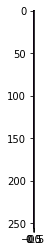

In [85]:
#Used to see the frame, useless bc we are seeing one frame at a time. In RL it was used bc we were using VecFrameStack 
plt.imshow(state[0])

In [10]:
#Testing the gym library
done = True
for step in range(10000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample()) #Random movements
    env.render()

env.close()

ValueError: could not broadcast input array from shape (84,4,84) into shape (4,84)